In [39]:
import gymnasium as gym
import pygame
from gymnasium.utils.play import play
# from gynasium.utils.play import pl
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import random

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'



In [15]:
env = gym.make("CartPole-v1",render_mode="human")

In [108]:
class V_Network(nn.Module):
    def __init__(self):
        super(V_Network, self).__init__()
        self.network = nn.Sequential(nn.Linear(4,24),
                                     nn.Tanh(),
                                     nn.Linear(24,16),
                                     nn.Tanh(),
                                     nn.Linear(16,1))
    def forward(self,state):
            return self.network(state)

class Policy_Network(nn.Module):
    def __init__(self):
        super(Policy_Network, self).__init__()
        self.network = nn.Sequential(nn.Linear(4,24),
                                     nn.Tanh(),
                                     nn.Linear(24,16),
                                     nn.Tanh(),
                                     nn.Linear(16,2),
                                     nn.Softmax(dim=0))
    def forward(self,state):
            return self.network(state)

In [115]:
# @torch.no_grad()
def train(epochs,lrQ,lrP,N_t,model_Q,model_P,max_steps,gamma,opt_func=torch.optim.Adam):
    epsilon =1e-5
    env = gym.make("CartPole-v1",render_mode="human")
    action_labels = torch.tensor([0,1])
    
    opt_Q = opt_func(model_Q.parameters(),lrQ)
    opt_P = opt_func(model_P.parameters(),lrP)
    history=[]
    for epoch in range(epochs):
        #epoch initialisation
        J_mean = 0
        epoch_mean_reward=0
        for trajectory in range(N_t):
            state , info = env.reset()
            state = torch.from_numpy(state)
            Q_loss=0
            total_reward = 0   #reward in a trajectory
            J=0
            for step in range(max_steps):
    
                P_actions = model_P.forward(state)
                prob = random.uniform(0, 1)
                if prob > P_actions[1].item():
                    action = 0
                else:
                    action = 1
                
    
                #New state and reward for state-action pair
                new_state, reward, done,truncated, info= env.step(action)
                new_state = torch.from_numpy(new_state)
    
                #Rewards for epoch and loop break
                total_reward += reward
                if done or truncated:
                    # print(epoch,":",total_reward)
                    Q_loss /= step  #average critic loss per step
                    Q_loss.backward()
                    opt_Q.step()
                    opt_Q.zero_grad()
                    
                    break
                
    
                #advantage
                Advantage = (reward + gamma*model_Q.forward(new_state) - model_Q.forward(state))
                Q_loss += (Advantage)**2
                
                            
                P_actions = torch.clamp(P_actions,min=epsilon,max=1-epsilon)  #to remove inf edge case                     
                J -= torch.log(P_actions[action])*Advantage.item()
                     
                
                #State-Change
                state = new_state
                
            J_mean+=J
            epoch_mean_reward+=total_reward
        
        #Updating the Policy Network
        J_mean=J_mean/N_t
        J_mean.backward()
        opt_P.step()
        opt_P.zero_grad()
        
        history.append(epoch_mean_reward/N_t)
        print(f"{epoch}:",epoch_mean_reward/N_t)
        
    env.close()
    return history

In [110]:
model_V = V_Network()
model_P = Policy_Network()

In [116]:
epochs=500
max_steps=300
no_trajectory = 5
gamma=0.9
lrQ=1e-4
lrP=1e-4

In [112]:
history=[]

In [117]:

history += train(epochs,lrQ,lrP,no_trajectory,model_V,model_P,max_steps,gamma)


0: 21.2
1: 24.4
2: 31.0
3: 16.4
4: 23.6
5: 16.8
6: 32.0
7: 25.0
8: 19.6
9: 16.8
10: 24.8
11: 24.0
12: 20.0
13: 15.0
14: 37.4
15: 24.6
16: 17.4
17: 20.2
18: 29.2
19: 19.2
20: 20.6
21: 24.8
22: 21.0
23: 24.6
24: 25.8
25: 26.8
26: 29.0
27: 32.4
28: 16.8
29: 14.2
30: 17.2
31: 25.4
32: 20.8
33: 32.8
34: 27.6
35: 24.0
36: 27.4
37: 28.2
38: 23.8
39: 30.8
40: 16.4
41: 17.6
42: 16.8
43: 33.8
44: 21.0
45: 24.2
46: 15.0
47: 18.2
48: 25.6
49: 30.2
50: 32.4
51: 34.4
52: 16.6
53: 17.0
54: 25.0
55: 18.8
56: 21.2
57: 14.8
58: 28.6
59: 33.0
60: 16.6
61: 24.0
62: 32.0
63: 20.4
64: 21.0
65: 23.6
66: 20.8
67: 30.2
68: 27.2
69: 19.4
70: 20.4
71: 15.2
72: 19.0
73: 19.4
74: 27.0
75: 23.2
76: 28.0
77: 28.0
78: 32.4
79: 19.0
80: 27.2
81: 27.2
82: 21.4
83: 21.0
84: 19.6
85: 22.6
86: 27.8
87: 22.8
88: 19.6
89: 15.2
90: 20.0
91: 27.4
92: 48.4
93: 20.0
94: 20.2
95: 18.4
96: 23.4
97: 17.2
98: 27.0
99: 20.2
100: 18.8
101: 24.4
102: 20.2
103: 21.8
104: 33.2
105: 39.8
106: 19.0
107: 17.6
108: 18.0
109: 23.0
110: 29.2


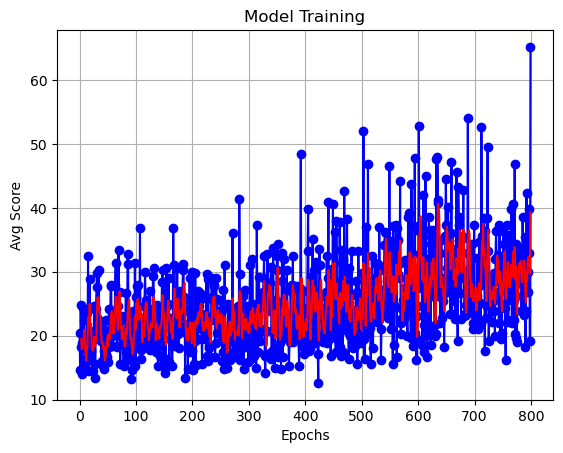

In [123]:
plt.plot(history, marker='o', linestyle='-', color='b')

window_size=4
smoothed_data = np.convolve(history, np.ones(window_size)/window_size, mode='valid')
smoothed_indices = range(window_size - 1, len(history))
plt.plot(smoothed_indices, smoothed_data, marker='', linestyle='-', color='r', label='Smoothed Data')

plt.title("Model Training")
plt.xlabel("Epochs")
plt.ylabel("Avg Score")
# plt.legend()
plt.grid(True)
plt.show()

In [119]:
def test(model,episodes):
    env = gym.make("CartPole-v1",render_mode="human")
    state,info = env.reset()
    state = torch.from_numpy(state)
    total_reward=0
    for ep in range(episodes):
       
        action = torch.argmax(model.forward(state)).item()
        # print(action)
        new_state, reward, done,truncated, info= env.step(action)
        # print(env.step(action))
        total_reward+=reward
        # print(f"{ep} Total reward:",total_reward)
        if done or truncated:
            print(total_reward)
            break
        state = torch.from_numpy(new_state)    
    env.close()
        

In [120]:
for i in range(20):
    print(i)
    test(model_P,100)

0
53.0
1
68.0
2
3
53.0
4
59.0
5
88.0
6
60.0
7
59.0
8
53.0
9
79.0
10
55.0
11
73.0
12
81.0
13
65.0
14
76.0
15
16
17
56.0
18
83.0
19
58.0
